# Experiment 6: Time Series Forecasting for Oil & Gas Production

**Course:** Introduction to Deep Learning | **Module:** Sequential Data Analysis

---

## Objective

Design and implement deep learning models for forecasting oil & gas production metrics using LSTM, GRU, and Transformer architectures to predict future production trends and optimize operations.

## Learning Outcomes

By the end of this experiment, you will:

1. Understand time series analysis and forecasting fundamentals
2. Implement LSTM and GRU networks for sequential prediction
3. Apply multi-step forecasting techniques for production planning
4. Handle seasonality, trends, and anomalies in time series data
5. Evaluate forecasting models using industry-standard metrics

## Background & Theory

**Time Series Forecasting** involves predicting future values based on historical sequential data. In oil & gas operations, accurate forecasting is crucial for production optimization, maintenance planning, and resource allocation.

**Key Components:**

- **Trend:** Long-term increase or decrease in data values
- **Seasonality:** Regular patterns that repeat over fixed periods
- **Cyclical Patterns:** Irregular fluctuations over longer periods
- **Noise:** Random variations in the data
- **Anomalies:** Unusual events that deviate from normal patterns

**Mathematical Foundation:**

- LSTM cell: f*t = σ(W_f[h*{t-1}, x*t] + b_f), i_t = σ(W_i[h*{t-1}, x_t] + b_i)
- GRU cell: r*t = σ(W_r[h*{t-1}, x*t]), z_t = σ(W_z[h*{t-1}, x_t])
- Multi-step prediction: ŷ*{t+1:t+h} = f*θ(x\_{t-w+1:t})
- Loss function: L = (1/n)Σ||y_i - ŷ_i||² (MSE) or (1/n)Σ|y_i - ŷ_i| (MAE)

**Applications in Oil & Gas:**

- Production forecasting for reservoir management
- Equipment failure prediction and maintenance scheduling
- Market demand forecasting and supply chain optimization
- Environmental monitoring and compliance prediction
- Economic modeling and investment planning


## Setup & Dependencies

**What to Expect:** This section establishes the Python environment for deep learning-based time series forecasting. We'll install PyTorch for neural networks, specialized time series libraries, and visualization tools for analyzing temporal patterns.

**Process Overview:**

1. **Package Installation:** Install PyTorch, pandas, matplotlib, seaborn, and time series analysis libraries
2. **Environment Configuration:** Set up device detection (CPU/GPU) and random seeds for reproducible experiments
3. **Time Series Tools:** Configure specialized libraries for temporal data analysis and forecasting
4. **Visualization Setup:** Apply ArivuAI styling for professional time series plots and analysis charts
5. **Data Directory Setup:** Establish paths for time series datasets and model outputs

**Expected Outcome:** A fully configured environment ready for time series forecasting with LSTM/GRU networks, including all temporal analysis tools and deep learning frameworks.


In [1]:
# Install required packages
import subprocess, sys
packages = ['torch', 'numpy', 'matplotlib', 'pandas', 'scikit-learn', 'seaborn']
for pkg in packages:
    try: __import__(pkg.replace('-', '_').lower())
    except ImportError: subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json, random, time
from pathlib import Path
from datetime import datetime, timedelta

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data directory setup
DATA_DIR = Path('data')
if not DATA_DIR.exists():
    DATA_DIR = Path('Expirements/data')
if not DATA_DIR.exists():
    DATA_DIR = Path('.')
    print('Warning: Using current directory for data')

# ArivuAI styling
plt.style.use('default')
colors = {'primary': '#004E89', 'secondary': '#3DA5D9', 'accent': '#F1A208', 'dark': '#4F4F4F'}
sns.set_palette([colors['primary'], colors['secondary'], colors['accent'], colors['dark']])

print(f'✓ PyTorch version: {torch.__version__}')
print(f'✓ Device: {device}')
print(f'✓ Data directory: {DATA_DIR.absolute()}')
print('✓ All packages installed and configured')
print('✓ Random seeds set for reproducible results')
print('✓ ArivuAI styling applied')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 1.7 MB/s  0:00:03 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:
      Successfully uninstalled numpy-2.3.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.17.0 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.6 which is incompatible.


/Users/pruthvirajv/Library/CloudStorage/OneDrive-ArivuAIInnovationsPrivateLimited(2)/Oil & Gas/GSSS-DeepLearning-Course/module1_dl_env/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


✓ PyTorch version: 2.4.0
✓ Device: cpu
✓ Data directory: /Users/pruthvirajv/Library/CloudStorage/OneDrive-ArivuAIInnovationsPrivateLimited(2)/Oil & Gas/GSSS-DeepLearning-Course/DeepLearning/Expirements/Experiment_6_Time_Series_Forecasting/data
✓ All packages installed and configured
✓ Random seeds set for reproducible results
✓ ArivuAI styling applied


## Time Series Data Generation

Create realistic oil & gas production time series with trends, seasonality, and anomalies.


In [2]:
class ProductionTimeSeriesGenerator:
    def __init__(self, config_path):
        """Initialize time series generator with configuration"""
        try:
            with open(config_path, 'r') as f:
                self.config = json.load(f)
            print('✓ Configuration loaded from JSON')
        except FileNotFoundError:
            print('Creating default configuration...')
            self.config = self._create_default_config()
        
        self.time_series_types = self.config['time_series_types']
        self.total_days = self.config['data_generation']['total_days']
    
    def _create_default_config(self):
        """Create default configuration if JSON file not found"""
        return {
            'time_series_types': {
                'oil_production': {'baseline': 2500, 'seasonal_amplitude': 200, 'trend_slope': -0.5, 'noise_level': 50},
                'gas_production': {'baseline': 15000, 'seasonal_amplitude': 1500, 'trend_slope': 0.8, 'noise_level': 300}
            },
            'data_generation': {'total_days': 1095, 'start_date': '2021-01-01'}
        }
    
    def generate_time_series(self):
        """Generate synthetic time series data for all production metrics"""
        # Create date range
        start_date = datetime.strptime(self.config['data_generation']['start_date'], '%Y-%m-%d')
        dates = [start_date + timedelta(days=i) for i in range(self.total_days)]
        
        # Initialize dataframe
        df = pd.DataFrame({'date': dates})
        df['day_of_year'] = df['date'].dt.dayofyear
        df['days_since_start'] = range(self.total_days)
        
        # Generate each time series
        for series_name, config in self.time_series_types.items():
            df[series_name] = self._generate_single_series(df, config)
        
        # Add external factors
        df = self._add_external_factors(df)
        
        # Inject anomalies
        df = self._inject_anomalies(df)
        
        return df
    
    def _generate_single_series(self, df, config):
        """Generate a single time series with trend, seasonality, and noise"""
        baseline = config['baseline']
        seasonal_amp = config['seasonal_amplitude']
        trend_slope = config['trend_slope']
        noise_level = config['noise_level']
        seasonal_period = config.get('seasonal_period', 365)
        
        # Trend component
        trend = trend_slope * df['days_since_start']
        
        # Seasonal component
        seasonal = seasonal_amp * np.sin(2 * np.pi * df['day_of_year'] / seasonal_period)
        
        # Noise component
        noise = np.random.normal(0, noise_level, len(df))
        
        # Combine components
        series = baseline + trend + seasonal + noise
        
        # Ensure positive values for production metrics
        if 'production' in config or 'pressure' in config:
            series = np.maximum(series, baseline * 0.1)
        
        return series
    
    def _add_external_factors(self, df):
        """Add external factors that influence production"""
        # Weather temperature (seasonal)
        df['weather_temperature'] = 25 + 20 * np.sin(2 * np.pi * df['day_of_year'] / 365) + np.random.normal(0, 3, len(df))
        
        # Market price (random walk with volatility)
        price_changes = np.random.normal(0, 2, len(df))
        df['market_price'] = 70 + np.cumsum(price_changes * 0.1)
        
        return df
    
    def _inject_anomalies(self, df):
        """Inject realistic anomalies into the time series"""
        anomaly_config = self.config.get('anomaly_patterns', {})
        
        for anomaly_type, config in anomaly_config.items():
            probability = config['probability']
            duration_range = config['duration_days']
            impact_range = config['production_impact']
            
            # Randomly select days for anomalies
            anomaly_days = np.random.choice(
                len(df), 
                size=int(len(df) * probability), 
                replace=False
            )
            
            for start_day in anomaly_days:
                duration = np.random.randint(duration_range[0], duration_range[1] + 1)
                impact = np.random.uniform(impact_range[0], impact_range[1])
                
                end_day = min(start_day + duration, len(df))
                
                # Apply impact to production metrics
                for col in ['oil_production', 'gas_production']:
                    if col in df.columns:
                        df.loc[start_day:end_day, col] *= (1 + impact)
        
        return df

# Initialize generator and create time series
generator = ProductionTimeSeriesGenerator(DATA_DIR / 'production_timeseries.json')
ts_data = generator.generate_time_series()

print(f'✓ Time series data generated:')
print(f'• Total days: {len(ts_data):,}')
print(f'• Features: {len(ts_data.columns)} ({list(ts_data.columns)})')
print(f'• Date range: {ts_data["date"].min()} to {ts_data["date"].max()}')
print(f'• Data shape: {ts_data.shape}')

# Display basic statistics
print('\nProduction metrics summary:')
production_cols = ['oil_production', 'gas_production', 'water_cut', 'wellhead_pressure']
for col in production_cols:
    if col in ts_data.columns:
        print(f'• {col}: {ts_data[col].mean():.1f} ± {ts_data[col].std():.1f}')

✓ Configuration loaded from JSON
✓ Time series data generated:
• Total days: 1,095
• Features: 10 (['date', 'day_of_year', 'days_since_start', 'oil_production', 'gas_production', 'water_cut', 'wellhead_pressure', 'reservoir_temperature', 'weather_temperature', 'market_price'])
• Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
• Data shape: (1095, 10)

Production metrics summary:
• oil_production: 2017.4 ± 584.2
• gas_production: 14011.3 ± 3912.3
• water_cut: 45.9 ± 6.7
• wellhead_pressure: 1034.9 ± 135.7


In [3]:
# Print descriptive statistics for production metrics
print("Production Data Statistics:\n")
print(ts_data[production_cols].describe().T)

Production Data Statistics:

                    count          mean          std         min  \
oil_production     1095.0   2017.411681   584.156702    6.297475   
gas_production     1095.0  14011.301145  3912.290750   43.958436   
water_cut          1095.0     45.945292     6.668429   31.889818   
wellhead_pressure  1095.0   1034.925784   135.735953  755.543214   

                            25%           50%           75%           max  
oil_production      1909.378518   2181.257855   2353.399462   2751.520250  
gas_production     14189.801425  15181.278461  16249.045978  17887.045374  
water_cut             40.697298     45.949282     51.199274     60.472539  
wellhead_pressure    936.587789   1036.675733   1131.120503   1325.292292  


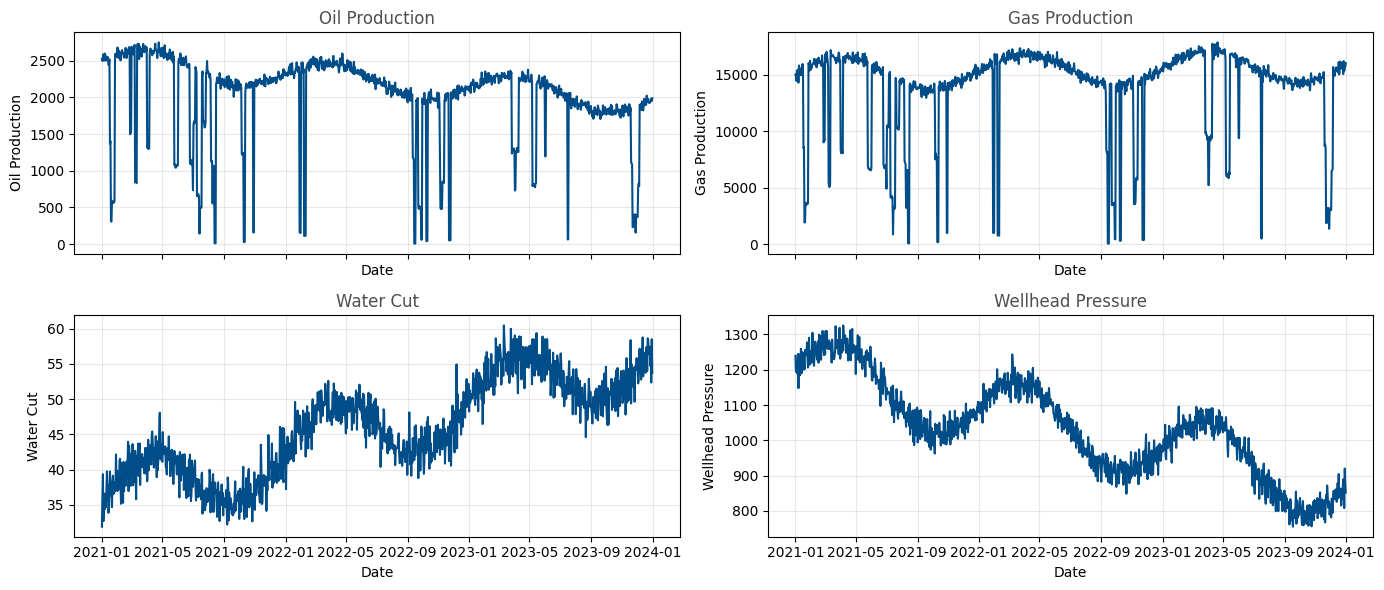

In [6]:
# Plot all production time series in a grid
n_cols = 2
n_rows = int(np.ceil(len(production_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), sharex=True)
axes = axes.flatten()

for i, prod_col in enumerate(production_cols):
    if prod_col in ts_data.columns:
        axes[i].plot(ts_data['date'], ts_data[prod_col], color=colors['primary'])
        axes[i].set_title(f'{prod_col.replace("_", " ").title()}', color=colors['dark'])
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(prod_col.replace('_', ' ').title())
        axes[i].grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Epoch 5/20 - Loss: 0.45045
Epoch 10/20 - Loss: 0.25284
Epoch 15/20 - Loss: 0.04414
Epoch 20/20 - Loss: 0.07625


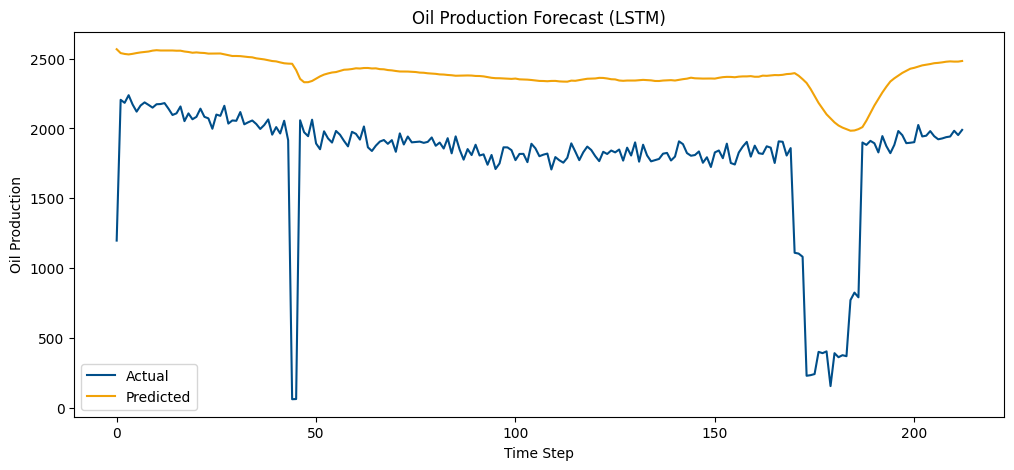

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Prepare data for time series prediction (LSTM example)

# Select a target column for prediction (e.g., 'oil_production')
target_col = 'oil_production'
feature_cols = ['oil_production', 'gas_production', 'water_cut', 'wellhead_pressure']

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_data[feature_cols])

# Create sequences for supervised learning
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]  # Predict next oil_production
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Use past 30 days to predict next day
X, y = create_sequences(scaled_data, seq_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define LSTM model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

input_dim = X_train.shape[2]
hidden_dim = 64
model = LSTMForecast(input_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = loss_fn(output, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.5f}")

# Prediction
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).cpu().numpy()
    y_true = y_test_t.cpu().numpy()

# Inverse scale predictions
oil_idx = feature_cols.index(target_col)
y_pred_inv = scaler.inverse_transform(
    np.concatenate([y_pred.reshape(-1,1), np.zeros((len(y_pred), len(feature_cols)-1))], axis=1)
)[:, oil_idx]
y_true_inv = scaler.inverse_transform(
    np.concatenate([y_true.reshape(-1,1), np.zeros((len(y_true), len(feature_cols)-1))], axis=1)
)[:, oil_idx]

# Plot results
plt.figure(figsize=(12,5))
plt.plot(range(len(y_true_inv)), y_true_inv, label='Actual', color=colors['primary'])
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicted', color=colors['accent'])
plt.title('Oil Production Forecast (LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Oil Production')
plt.legend()
plt.show()